## Billy Parmenter ~ 7526387

1. Consider the heart disease dataset in pandas dataframe

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns; 
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

sns.set(rc={'figure.figsize':(11.7,8.27)})

def evaluate_data(data):
  display(data.head())
  print('Null values:', data.isnull().sum().sum())
  pd.set_option('display.max_columns', None)
  display(data.describe())
  pd.reset_option('display.max_columns')

heart_csv = '../../data/heart.csv'
heart_data = pd.read_csv(heart_csv)

evaluate_data(heart_data)
print(heart_data['HeartDisease'].value_counts())
print(round(heart_data['HeartDisease'].value_counts()[1]/(heart_data['HeartDisease'].value_counts()[0] + heart_data['HeartDisease'].value_counts()[1] )* 100, 2), '% pd')

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Null values: 0


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


HeartDisease
1    508
0    410
Name: count, dtype: int64
55.34 % pd


2. Remove outliers using mean,median,Z score. 

In [12]:
def remove_outliers_zscore(data, z_threshold=3, skip_columns=[]):
    num_removed = {}
    
    for column in data.columns:
        if column in skip_columns:
            continue
        
        mean = np.mean(data[column])
        std = np.std(data[column])
        z_scores = np.abs((data[column] - mean) / std)
        outliers = z_scores > z_threshold
        
        num_outliers_removed = np.sum(outliers)
        num_removed[column] = num_outliers_removed
        
        data = data[~outliers]
    
    data.reset_index(drop=True, inplace=True)
    
    print("Number of removed outliers:", num_removed)
    return data

def find_binary_columns(data, threshold=150):
    num_unique_values = data.nunique()

    median = np.median(num_unique_values)
    median_absolute_deviation = np.median(np.abs(num_unique_values - median))
    modified_z_scores = 0.6745 * (num_unique_values - median) / median_absolute_deviation

    return num_unique_values[modified_z_scores < threshold].index.tolist()

In [13]:
categorical_columns = find_binary_columns(heart_data, threshold=20)
categorical_columns.append('HeartDisease')
filtered_data = remove_outliers_zscore(heart_data, skip_columns=categorical_columns)

Number of removed outliers: {'Age': 0, 'RestingBP': 8, 'Cholesterol': 3, 'MaxHR': 1, 'Oldpeak': 7}


3. Convert text columns to numbers using label encoding and one hot encoding

In [14]:
from sklearn.preprocessing import LabelEncoder

def label_encode(data, columns_to_encode):
    encoded_data = data.copy()
    label_encoder = LabelEncoder()
    
    for column in columns_to_encode:
        encoded_data[column] = label_encoder.fit_transform(data[column])
    
    return encoded_data

In [15]:
encoded_data = label_encode(filtered_data, categorical_columns)
encoded_data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
894,45,1,3,110,264,0,1,132,0,1.2,1,1
895,68,1,0,144,193,1,1,141,0,3.4,1,1
896,57,1,0,130,131,0,1,115,1,1.2,1,1
897,57,0,1,130,236,0,0,174,0,0.0,1,1


4. Apply scaling

In [16]:
def scale_data(data, skip_columns=[]):
    ret_data = data.copy()
    
    columns_to_scale = [col for col in ret_data.columns if col not in skip_columns]
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(ret_data[columns_to_scale])
    
    ret_data[columns_to_scale] = scaled_data
    
    return ret_data

In [17]:
scaled_data = scale_data(encoded_data, categorical_columns)
scaled_data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.428154,1,1,0.465900,0.849636,0,1,1.384320,0,-0.855469,2,0
1,-0.475855,0,2,1.634714,-0.168122,0,1,0.752973,0,0.137516,1,1
2,-1.745588,1,1,-0.118507,0.793612,0,2,-1.535661,0,-0.855469,2,0
3,-0.581666,0,0,0.349019,0.149344,0,1,-1.141069,1,0.634008,1,1
4,0.053200,1,2,1.050307,-0.028064,0,1,-0.588640,0,-0.855469,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
894,-0.899099,1,3,-1.287320,0.616205,0,1,-0.194048,0,0.336112,1,1
895,1.534554,1,0,0.699663,-0.046738,1,1,0.161085,0,2.520678,1,1
896,0.370633,1,0,-0.118507,-0.625646,0,1,-0.864854,1,0.336112,1,1
897,0.370633,0,1,-0.118507,0.354763,0,0,1.463238,0,-0.855469,1,1


5. Build a machine learning classification model using support vector machine. Demonstrate the standalone model as well as Bagging model and include observations about the performance

In [22]:
def split_data(data, test_size=0.2):
  X = data.drop(data.columns[-1], axis=1)
  y = data[data.columns[-1]]
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  return X_train, X_test, y_train, y_test

def evaluate_model(y_test, y_pred, labels):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)
  print("ROC AUC Score:", roc_auc, '\n')

  cr = classification_report(y_test, y_pred, target_names=labels, zero_division=0)
  print(cr)
  
  cm = confusion_matrix(y_test, y_pred)

  true_positives = cm[1, 1]
  false_negatives = cm[1, 0]
  positive_recall = true_positives / (true_positives + false_negatives)
  print('Positive Recall:', positive_recall)
  
  sns.heatmap(cm.T, square=True, annot=True, fmt='d', xticklabels = labels, yticklabels = labels)
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.show()

def cross_vall_eval(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    print("Cross-Validation Accuracy Scores:", scores)
    print("Mean Cross-Validation Accuracy:", scores.mean())
    print("Standard Deviation of Cross-Validation Accuracy:", scores.std())

def evaluate_models(data, models):
  # Preprocessing and Standardization
  X_train, X_test, y_train, y_test = split_data(data)

  for model in models:
    print('\n\t~~~~\t', type(model).__name__, '\t~~~~\n')
    # Train the model
    model.fit(X_train, y_train)

    # Measure Model 
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    cross_vall_eval(model, X_train, y_train)
    evaluate_model(y_test, y_pred, ['Negative', 'Positive'])


	~~~~	 SVC 	~~~~

Cross-Validation Accuracy Scores: [0.90972222 0.86111111 0.875      0.89583333 0.82517483]
Mean Cross-Validation Accuracy: 0.8733682983682984
Standard Deviation of Cross-Validation Accuracy: 0.029331885461660333
Accuracy: 0.8
Precision: 0.7857142857142857
Recall: 0.8369565217391305
F1 Score: 0.8105263157894738
ROC AUC Score: 0.7991600790513833 

              precision    recall  f1-score   support

    Negative       0.82      0.76      0.79        88
    Positive       0.79      0.84      0.81        92

    accuracy                           0.80       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.80      0.80      0.80       180

Positive Recall: 0.8369565217391305


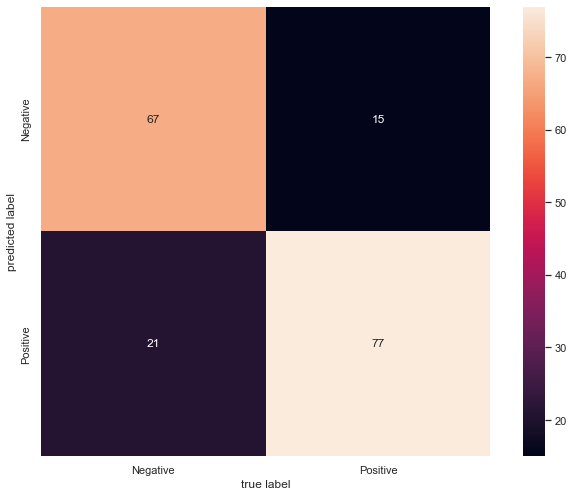


	~~~~	 BaggingClassifier 	~~~~

Cross-Validation Accuracy Scores: [0.90277778 0.88888889 0.85416667 0.88888889 0.83216783]
Mean Cross-Validation Accuracy: 0.8733780108780108
Standard Deviation of Cross-Validation Accuracy: 0.026126138416646728
Accuracy: 0.7888888888888889
Precision: 0.7755102040816326
Recall: 0.8260869565217391
F1 Score: 0.8
ROC AUC Score: 0.7880434782608696 

              precision    recall  f1-score   support

    Negative       0.80      0.75      0.78        88
    Positive       0.78      0.83      0.80        92

    accuracy                           0.79       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.79      0.79      0.79       180

Positive Recall: 0.8260869565217391


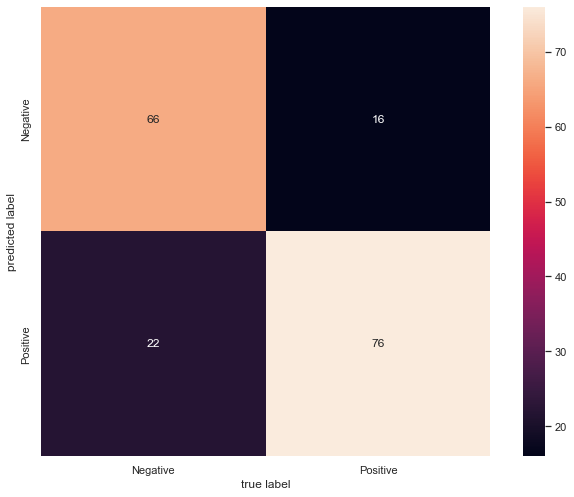

In [19]:
evaluate_models(
    scaled_data,
    [
      SVC(kernel='linear'),
      BaggingClassifier(base_estimator=SVC(kernel='linear'))
    ]
)

6. Now use decision tree classifier. Use standalone model as well as Bagging and check if you notice any difference in performance


	~~~~	 DecisionTreeClassifier 	~~~~

Cross-Validation Accuracy Scores: [0.79861111 0.76388889 0.85416667 0.79166667 0.81118881]
Mean Cross-Validation Accuracy: 0.8039044289044288
Standard Deviation of Cross-Validation Accuracy: 0.02952416044773189
Accuracy: 0.7888888888888889
Precision: 0.7628865979381443
Recall: 0.8314606741573034
F1 Score: 0.7956989247311828
ROC AUC Score: 0.7893567107050253 

              precision    recall  f1-score   support

    Negative       0.82      0.75      0.78        91
    Positive       0.76      0.83      0.80        89

    accuracy                           0.79       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.79      0.79      0.79       180

Positive Recall: 0.8314606741573034


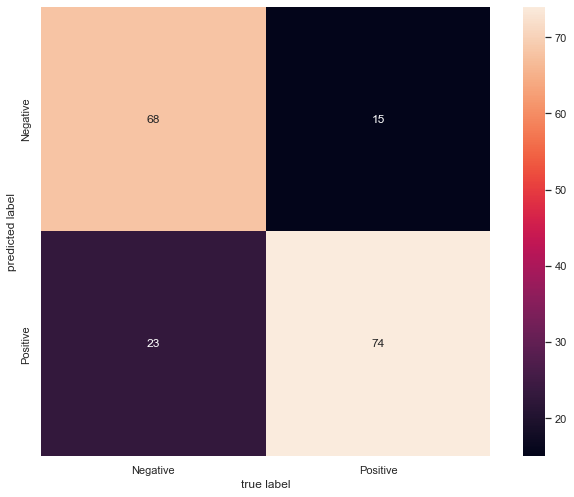


	~~~~	 BaggingClassifier 	~~~~

Cross-Validation Accuracy Scores: [0.81944444 0.79861111 0.88888889 0.83333333 0.83916084]
Mean Cross-Validation Accuracy: 0.8358877233877233
Standard Deviation of Cross-Validation Accuracy: 0.02995426175062065
Accuracy: 0.8388888888888889
Precision: 0.8
Recall: 0.898876404494382
F1 Score: 0.8465608465608465
ROC AUC Score: 0.839548092357081 

              precision    recall  f1-score   support

    Negative       0.89      0.78      0.83        91
    Positive       0.80      0.90      0.85        89

    accuracy                           0.84       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.84      0.84      0.84       180

Positive Recall: 0.898876404494382


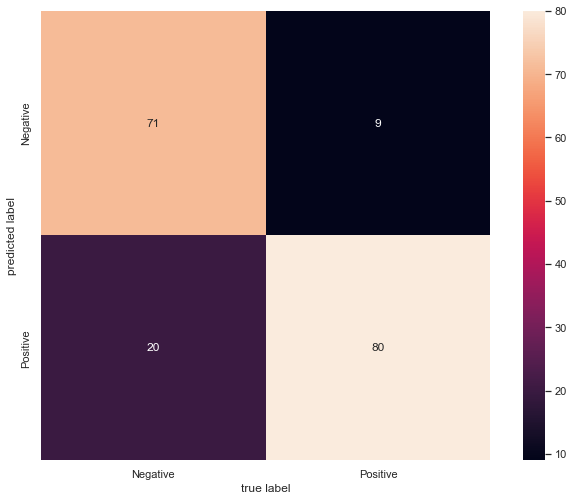

In [20]:
evaluate_models(
    scaled_data,
    [
      DecisionTreeClassifier(),
      BaggingClassifier(base_estimator=DecisionTreeClassifier())
    ]
)

7. Comparing performance of svm and decision tree classifier figure out where it makes most sense to use bagging and why. 

Bagging helps improve model generalization by reducing the variance and enhancing the model's ability to capture patterns. Bagging is most beneficial when dealing with models that have high variance and are prone to overfitting, as seen in the case of the Decision Tree Classifier.
